# Interpretable Patches - Mascharak

- This tutorial attempts to find wounding related genes using only the data originating from v3 sequencing runs contained in the [Vu (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9901190/) dataset.

- The data is a combination of aged & young cells collected at time points 0DPW (uninjured), 4DPW and 7DPW.


- Throughout this tutorial, we will use the workflow package with Patches to find genes that are associated with the 4DPW timepoint. 

In [1]:
# Minimal mports
from ladder.data import get_data
from ladder.scripts import InterpretableWorkflow # Our workflow object to run the interpretable model
import umap, torch, pyro, os # To set seeds + umaps
import torch.optim as opt # For defining out optimizer


# For plotting
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For data loading
import anndata as ad
import scanpy as sc

## Formatting The Data

The workflows use [anndata](https://anndata.readthedocs.io/en/latest/) objects as input. Specifically, the data we provide can also be manually downloaded [here](https://drive.google.com/file/d/1quCP3403hOPG5Q8cy1KWZui_a0mJrQ5J/view?usp=drive_link). 

In [2]:
# Download the data object
get_data("Mascharak") 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36.0M/36.0M [00:00<00:00, 97.2MB/s]

Object saved at ./data/mascharak_2022_tn_wh.h5ad


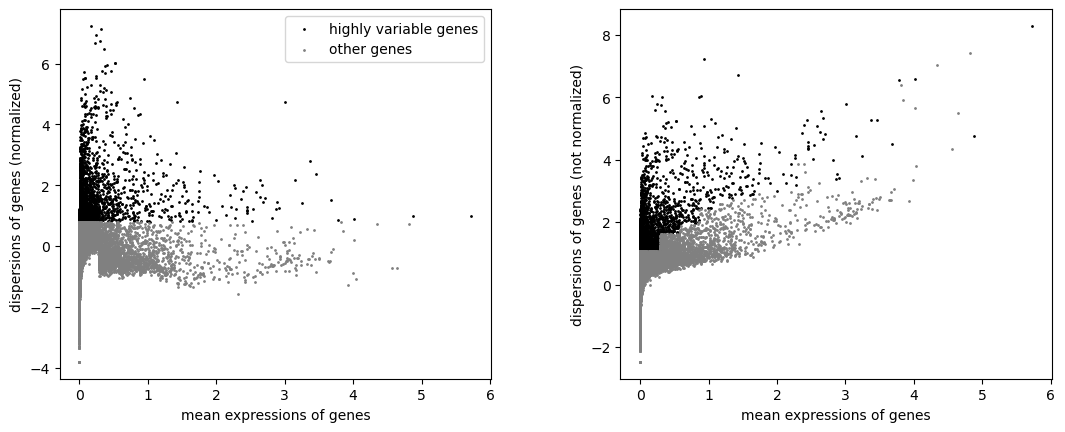

In [3]:
# Load the anndata object
anndata = ad.read_h5ad("data/mascharak_2022_tn_wh.h5ad")
anndata.layers["normalized"] = anndata.X

# Find/subset HVGs & swap to raw counts
sc.pp.highly_variable_genes(anndata, n_top_genes=3000)
sc.pl.highly_variable_genes(anndata)

anndata = anndata[:, anndata.var["highly_variable"]]
anndata.X = anndata.layers["counts"]

In [4]:
anndata

View of AnnData object with n_obs × n_vars = 2284 × 3000
    obs: 'time', 'treatment', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'leiden', 'broad_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'broad_type_colors', 'dendrogram_broad_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'time_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'P

## Initializing the Interpretable Workflow
- Models can be run through two workflow interfaces: **InterpretableWorkflow** and **CrossConditionWorkflow** (see the corresponding [tutorial](crossconditional_vu_tutorial.ipynb))

- Once initialized, you can train and evaluate the model through the workflow interface. 

In [ ]:
# Initialize workflow object
workflow = InterpretableWorkflow(anndata, verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["time", "treatment", "broad_type"]
workflow.prep_model(factors, model_type='Patches', model_args={'ld_normalize' : True})

workflow.run_model(max_epochs=10000, convergence_threshold=1e-5, convergence_window=10000) # Lower the convergence threshold if you need a more accurate model, will increase training time
workflow.save_model("params/mascharak_ld")

## Observing the Losses

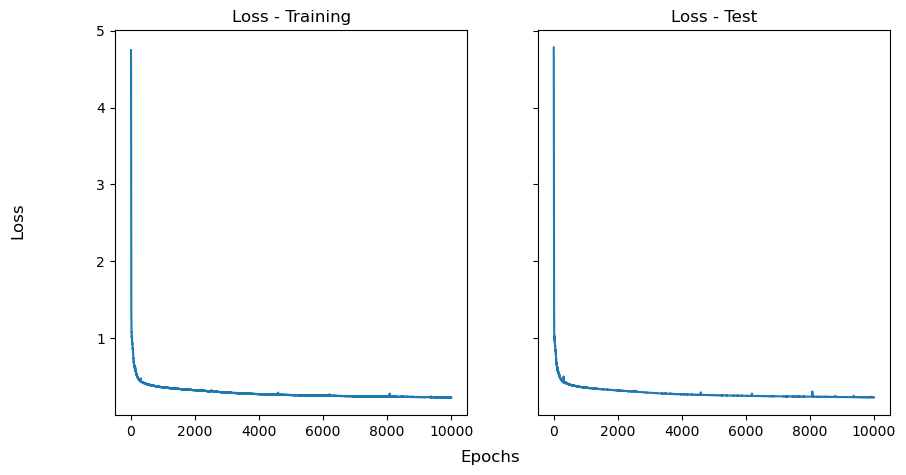

In [6]:
workflow.plot_loss()

## Obtaining Latent Embeddings

In [7]:
workflow.write_embeddings()
workflow.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: X_pca, X_umap, patches_w_latent, patches_z_latent

## Evaluation of Model Reconstruction

In [8]:
workflow.evaluate_reconstruction()

Calculating RMSE ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


Calculating Profile Correlation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]


Calculating 2-Sliced Wasserstein ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


Calculating Chamfer Discrepancy ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 585.80it/s]

Results
RMSE : 10.877 +- 0.757
Profile Correlation : 0.92 +- 0.005
2-Sliced Wasserstein : 21.077 +- 1.42
Chamfer Discrepancy : 159.829 +- 86.174


{'RMSE': [10.877, 0.757],
 'Profile Correlation': [0.92, 0.005],
 '2-Sliced Wasserstein': [21.077, 1.42],
 'Chamfer Discrepancy': [159.829, 86.174]}

## Interpretability - Common and Conditional Gene Loadings

- Patches can generate condition-specific scores for each gene, describing the association of the gene and the condition, even if the conditions were always encountered combinatorially.

- Positive/Negative values mean that the given gene tends to be expressed relatively more/less for that condition compared to the basal state.

In [9]:
workflow.get_conditional_loadings()
workflow.get_common_loadings()
workflow.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,...,Fibroblast_score_Patches,Gamma-delta T Cell_score_Patches,Granulocyte_score_Patches,Macrophage_score_Patches,Melanocyte_score_Patches,Neutrophil_score_Patches,Red Blood Cell_score_Patches,Skeletal Muscle_score_Patches,T Cell_score_Patches,common_score_Patches
Sox17,False,False,False,14,0.018039,0.017878,99.540833,55.0,4.025352,True,...,0.126722,0.005121,0.073156,-0.224584,-0.135115,0.113830,-0.104980,0.100207,0.134213,0.092391
Adhfe1,False,False,False,27,0.010495,0.010441,99.114464,32.0,3.496508,True,...,0.040870,0.103973,-0.257579,-0.281439,-0.132003,0.034305,0.099367,0.087370,0.023955,0.536997
Cpa6,False,False,False,20,0.007871,0.007841,99.344047,24.0,3.218876,True,...,0.115090,0.094494,-0.050590,0.071744,0.157219,0.069963,0.097167,-0.020337,-0.088484,0.356553
Prex2,False,False,False,133,0.088882,0.085151,95.637914,271.0,5.605802,True,...,0.177728,-0.063112,0.151966,0.002831,-0.114980,-0.188440,0.072596,0.014520,-0.039014,-0.161527
Sulf1,False,False,False,168,0.126927,0.119494,94.489997,387.0,5.961005,True,...,0.168314,-0.109854,0.161246,-0.019156,0.215137,0.149358,-0.025992,0.086490,0.068549,-0.280242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gfra1,False,False,False,80,0.065595,0.063534,97.376189,200.0,5.303305,True,...,0.198698,0.024065,-0.002350,-0.106101,-0.037805,-0.134026,0.049773,-0.050908,-0.183474,-0.232669
Slc18a2,False,False,False,33,0.036733,0.036075,98.917678,112.0,4.727388,True,...,-0.173744,0.156180,0.134977,-0.064383,0.069190,0.065861,-0.296098,-0.083482,0.225230,-0.013733
Rps12-ps3,False,True,False,368,0.145622,0.135947,87.930469,444.0,6.098074,True,...,-0.075951,-0.060358,0.086086,0.011824,-0.006700,0.076035,0.034543,0.037943,-0.018578,-0.259352
Emx2,False,False,False,69,0.030830,0.030364,97.736963,94.0,4.553877,True,...,0.201313,0.149887,0.189365,-0.197546,0.185826,-0.089447,-0.022594,-0.010877,-0.275604,0.682746


## Bonus

1. Run the cell below to get the top 200 genes
2. Copy & Paste the output to the [Gene Ontology Resource](https://geneontology.org/)
3. Select 'biological process' and 'Mus Musculus' from the list below and click launch.

In [11]:
for gene in (workflow.anndata.var["Macrophage_score_Patches"]).sort_values(ascending=False)[:200].index:
    print(gene)

Lyz2
Lpl
Cd74
Cd14
Fn1
H2-Ab1
Ms4a1
H2-Aa
Psap
Thbs1
H2-Eb1
Map3k12
Ms4a6d
Mrc1
Msr1
Fscn1
Ccl8
Mmp14
Pla2g7
Mmp19
Apol7c
Hmox1
Fcgr1
Folr2
Fcrls
C1qc
Mgl2
Spic
Adora2b
Cd79a
Lgmn
Tlr2
Mmp12
Lifr
Gm26782
Retnla
Gsn
C1qb
Mmp13
Mafb
Gab1
Fxyd2
Lipa
Clec4e
Naaa
Lyz1
F13a1
H2-Ob
Chil3
Timd4
C1qa
Lrrc32
Txndc16
Il1rn
Lhfpl2
Sdc3
Cd207
Ctsl
Slc11a1
Aif1
H2-DMb1
Cd209f
Tbc1d4
Sh2b2
Rab32
Slc7a11
Lgals3
Ifi207
Gsr
G0s2
Mx1
Ifitm6
Cd38
Klk1
Pdpn
Cacnb3
Hbb-bt
Atr
Tnfaip2
9130015A21Rik
Adgre1
Thbd
Apoe
Rhov
Ms4a4c
Gla
C3
AI839979
Tppp3
Fnip2
F10
Mcoln2
Polr2l
Il1b
H2-M2
Cyp7b1
Wfdc17
Arg2
Ly86
Usp18
Gatm
Yae1d1
Il10
Fgd2
Zmynd15
Il27
Cox6a2
2010013B24Rik
Clec4b1
Cmtr1
Mzb1
Cdc42ep2
Cebpb
Ccl24
Ftl1
Oasl1
Anxa3
Ear2
Ctsk
Ccl12
Zfp36
Akr1b8
Ecm1
Tnfsf9
Rnase4
Bcl2l14
Igf1
Pf4
Ifi204
Pltp
Cbr3
Pmp22
Ccl2
Il1a
Lepr
Clec4d
A330069E16Rik
Arl11
Hpgd
Ace
Cd209d
Flrt3
Adam23
Clec10a
Daglb
Ccl22
Mrgpra2a
Tbc1d8
Npy
Cd300e
Fcrla
Gas6
Cpne2
Ly6i
Olfm1
Dennd4b
Cxcl16
Cfh
Cstb
Asprv1
Procr
Fmnl2
Fam102b
Dapk1